# Gene set enrichment analysis: pathways

Having identified a number of differentially expressed genes between the CD and HFD diets on Day 5, we are interested in their functional composition. We will try to find gene classes that have an unusually large amount of differentially expressed genes (i.e. more than it would be expected by random chance).

Such gene classes can be defined in a number of ways: the chromosome they are found on, their function / properties (e.g. kinase activity, membrane protein), or the biochemical pathways they play a role in.

There are multiple data sources you can obtain such gene sets from. Position is found in the mouse genome annotation, function and properties in the Gene Ontology (GO) database, and biochemical pathways in KEGG, Reactome, etc. Today we will use KEGG pathways as our reference gene sets, but our analysis could easily be adapted to other kinds of gene sets.

In [1]:
# imports
import pandas as pd
from Bio.KEGG.REST import *
from Bio.KEGG.KGML import KGML_parser

from IPython.display import Image

from io import StringIO

## KEGG REST service and visualizing KEGG pathways
You can find documentation about the REST service itself and how to use it directly using URLs in a browser here: http://www.genome.jp/kegg/rest/keggapi.html

The following link shows a Jupyter notebook that contains code examples that are very similar to the tasks in this Pathways notebook, and almost in the same order, so take a look if you need help with anything from access to the KEGG REST service using Biopython to coloring nodes in a pathway visualization:
http://nbviewer.jupyter.org/github/widdowquinn/notebooks/blob/master/Biopython_KGML_intro.ipynb

## Task 1: KEGG and gene ID mapping

Familiarize yourself with the KEGG Rest interface and how to access it with Biopyhton.<br>
Before you start solving task 1.1, read its task description, look at and run all code examples given there. Try to understand what happens by recreating some REST calls as URL calls in your browser. The Biopython functions `kegg_list` and `kegg_link` simply wrap these URL calls into a function and return the response in plain text.

E.g. accessing the URL http://rest.kegg.jp/list/pathway/hsa lists all pathways associated with humans and is equivalent to calling `kegg_list('pathway', 'hsa').read()` in Python. (Organsim IDs: `hsa`: Homo Sapiens, `mmu`: Mus musculus)

### 1.1: Extract gene lists for all (mouse) KEGG pathways and store them
Below is some example code showing how to get data out of the KEGG REST service in general.
It lists all the mouse pathways and extracts the pathway IDs from the REST response, then pulls the gene list for one pathway.

* The raw list of pathways looks like this:<br>
path:mmu00010	Glycolysis / Gluconeogenesis - Mus musculus (mouse)<br>
path:mmu00020	Citrate cycle (TCA cycle) - Mus musculus (mouse)<br>
path:mmu00030	Pentose phosphate pathway - Mus musculus (mouse)<br>
path:mmu00040	Pentose and glucuronate interconversions - Mus musculus (mouse)<br>
path:mmu00051	Fructose and mannose metabolism - Mus musculus (mouse)<br>
path:mmu00052	Galactose metabolism - Mus musculus (mouse)<br>
path:mmu00053	Ascorbate and aldarate metabolism - Mus musculus (mouse)<br>
...<br>
(path:ID)(TAB)(Description with spaces)


* The raw list of genes in a pathway looks like this:<br>
path:mmu00010	mmu:100042025<br>
path:mmu00010	mmu:103988<br>
path:mmu00010	mmu:106557<br>
path:mmu00010	mmu:110695<br>
path:mmu00010	mmu:11522<br>
path:mmu00010	mmu:11529<br>
path:mmu00010	mmu:11532<br>
...<br>
(path:ID)(TAB)(organismID:geneID)
<br>

The gene identifiers are so-called Entrez ID's, since KEGG chose to use the Entrez system.

* Extend the code to get lists of gene IDs for each pathway<br>
* Store the lists in a way that allows convenient lookup of all genes in each pathway.
A DataFrame called `pw_entrez` with two columns should do: `pathway` and `entrez`, where the pathway ID will be equal for all genes from one pathway. From this you can extract all genes of a pathway using the first column. Be aware that neither of the two columns is a unique identifier, as each gene may be present in multiple pathways: it's a typical case of N-to-N ("many-to-many") mapping.
 
Beware: you will need to do many calls to the REST service to retrieve pathway information and this might take a lot of time, partly because of restrictions to the number of calls per second allowed by Biopython. Make sure your code works as expected on e.g. 3 Pathways before you start to process all ~300 of them.

In [2]:
# get all pathways from organism 'mmu' (Mus musculus)
pathways_response = kegg_list('pathway', 'mmu').read()
# Format = path:ID Description

In [3]:
# Split the response on "\n" newline characters, split the lines on "\t" characters.
# Or read on a bit and adapt the trick in the next code block.
# Either way, store them in a pandas Series indexed by pathway ID's.

pw_names = [x.split('\t') for x in pathways_response.strip().split('\n')]
pw_names = pd.DataFrame(pw_names, columns=['path', 'name']).set_index('path')
pw_names

,name
path,
path:mmu00010,Glycolysis / Gluconeogenesis - Mus musculus (m...
path:mmu00020,Citrate cycle (TCA cycle) - Mus musculus (mouse)
path:mmu00030,Pentose phosphate pathway - Mus musculus (mouse)
path:mmu00040,Pentose and glucuronate interconversions - Mus...
path:mmu00051,Fructose and mannose metabolism - Mus musculus...
...,...
path:mmu05412,Arrhythmogenic right ventricular cardiomyopath...
path:mmu05414,Dilated cardiomyopathy - Mus musculus (mouse)
path:mmu05415,Diabetic cardiomyopathy - Mus musculus (mouse)


In [4]:
# use kegg_link(organism, pathway).read() to get the list of genes for each pathway

# example for one pathway:
example_gene_list = kegg_link('mmu', 'path:mmu00010').read()
# print(exampleGeneList)

# A neat trick to turn this directly into a pandas DataFrame
# is to use StringIO to simulate a CSV input file:
tmp_df = pd.read_csv(StringIO(example_gene_list), sep='\t', header=None)
tmp_df

# Extend this code so that you obtain all pathway tables

,0,1
0,path:mmu00010,mmu:103988
1,path:mmu00010,mmu:106557
2,path:mmu00010,mmu:110695
3,path:mmu00010,mmu:11522
4,path:mmu00010,mmu:11529
...,...,...
62,path:mmu00010,mmu:72157
63,path:mmu00010,mmu:72535
64,path:mmu00010,mmu:73458
65,path:mmu00010,mmu:74551


In [5]:
pw_df = []
for pw in pw_names.index:
    gene = kegg_link('mmu', pw).read()
    tmp_df = pd.read_csv(StringIO(gene), sep='\t', header=None)
    pw_df.append(tmp_df)

### 1.2: Create the pathway-to-gene DataFrame
How many rows does the `pw_entrez` DataFrame have? How many unique Entrez identifiers are in there?
Store the DataFrame as a csv file so that you can load it back up easily if necessary.


In [6]:
pw_entrez = pd.concat(pw_df, ignore_index=True)
pw_entrez.columns = ['path', 'entrez']
pw_entrez

,path,entrez
0,path:mmu00010,mmu:103988
1,path:mmu00010,mmu:106557
2,path:mmu00010,mmu:110695
3,path:mmu00010,mmu:11522
4,path:mmu00010,mmu:11529
...,...,...
35796,path:mmu05418,mmu:723893
35797,path:mmu05418,mmu:74769
35798,path:mmu05418,mmu:75600
35799,path:mmu05418,mmu:75886


In [7]:
pw_entrez['entrez'].nunique()

8914

### 1.3: Create a conversion table between gene identifier formats

http://www.informatics.jax.org/downloads/reports/MGI_Gene_Model_Coord.rpt <br>
The file above contains mappings between different identifier types, including the Entrez IDs that KEGG uses and the gene symbols we have in the DE data.
Download and read in this file, then use the respective columns to map the Entrez ID numbers to gene symbols.

Create a DataFrame with two columns:
* `gene` (to match the index name we had used in the DE notebook) and
* `entrez` to match our KEGG `pathway_entrez` table.

Watch out! Pandas may convert the Entrez ID's to floating point numbers when loading the csv. Also, the "mmu:" prefix which KEGG uses is missing from them. Turn those `12345.0`-like floating point values to `mmu:12345` strings, otherwise you will have a hard time matching them with KEGG pathways.

In [8]:
mgi = pd.read_csv('../example_data/MGI_Gene_Model_Coord.rpt', index_col=False, sep='\t')
mapping_df = mgi.iloc[:,[2,5]].dropna()
mapping_df.columns = ['gene', 'entrez']

def convert(gene):
    gene = int(gene)
    return 'mmu:'+str(gene)
mapping_df['entrez'] = mapping_df['entrez'].apply(convert)

In [9]:
mapping_df

,gene,entrez
0,a,mmu:50518
1,Pzp,mmu:11287
2,Abl1,mmu:11350
3,Abl2,mmu:11352
4,Scgb1b27,mmu:11354
...,...,...
64994,Gm51520,mmu:115488003
64995,Gm51522,mmu:115488029
64996,Gm51612,mmu:115489115
64997,Gm51613,mmu:115489130


## Task 2: Gene Set Enrichment

### 2.1: Prepare your differential expression data

* Read in the csv file you exported the `diffexpr` DataFrame into in the Differential Expression notebook
* Ensure you have the boolean column `is_de`, with criteria that you can perhaps adjust later. You can start use p_mwu_corr < 0.01 and |log2fold| > 0.2.

In [10]:
diffexpr = pd.read_csv('../output/diffexpr.csv', index_col=False)
diffexpr['is_de'] = ((diffexpr['mwu pvals corr']<0.01) & (diffexpr['log2fc'].abs()>0.2))
diffexpr

,gene,log2fc,wilcoxon pvals,ttest pvals,mwu pvals,wilcoxon pvals corr,ttest pvals corr,mwu pvals corr,is_de,label
0,544988,-0.041726,0.007690,2.471637e-02,2.461669e-03,0.016986,0.051565,0.007086,False,grey
1,100043387,-0.094410,0.029482,1.105006e-01,1.588075e-01,0.053852,0.179216,0.238169,False,grey
2,0610007C21Rik,-0.011872,0.504683,5.986195e-01,3.684131e-01,0.584529,0.688445,0.468540,False,grey
3,0610007L01Rik,0.007372,0.530015,6.891828e-01,9.561658e-01,0.607698,0.765220,0.971427,False,grey
4,0610007P08Rik,-0.061718,0.030539,6.733311e-02,4.618156e-02,0.055444,0.119326,0.085016,False,grey
...,...,...,...,...,...,...,...,...,...,...
21830,Zzz3,0.153692,0.000002,2.316426e-07,9.252459e-07,0.000021,0.000002,0.000008,False,grey
21831,a,-0.059923,0.121381,1.713445e-01,2.760128e-01,0.178872,0.256500,0.372528,False,grey
21832,l7Rn6,-0.122462,0.000965,8.665480e-03,1.454909e-02,0.002906,0.021283,0.032398,False,grey
21833,mCG_21548,-0.051026,0.204119,1.807908e-01,2.343324e-01,0.277448,0.268068,0.326371,False,grey


### 2.2: Perform gene set enrichment with the KEGG gene sets you extracted in Task 1
Several tests are suitable for our purpose: the $\chi^2$ test we had used before, Fisher's exact test, or the simplest binomial test.<br>

Let's use the binomial test today. There is a relatively small fraction of genes in any one pathway, so the "not in pathway" row of the contingency tables would be nearly constant, and much larger than the "in pathway" row. So a binomial simplification is perfectly reasonable for this task.

To do a binomial test, you will first have to determine the "number of trials" / "number of successes" / "probability of success" parameters. Remember, the latter is independent of your pathway, so you'll only have to calculate it once, and use the same parameter for all pathways.

Avoid writing `for` loops here. Use pandas' efficient grouping and aggregation methods.

Details to think about: How do you want to treat Entrez ID's that have no corresponding measurements in the microarray experiment? What about those that have multiple?

In [11]:
diffexpr = diffexpr.merge(mapping_df, on='gene').merge(pw_entrez, on='entrez')
diffexpr 

,gene,log2fc,wilcoxon pvals,ttest pvals,mwu pvals,wilcoxon pvals corr,ttest pvals corr,mwu pvals corr,is_de,label,entrez,path
0,1300017J02Rik,0.102872,0.000249,0.000936,0.000757,0.000925,0.003153,0.002565,False,grey,mmu:71775,path:mmu04066
1,1300017J02Rik,0.102872,0.000249,0.000936,0.000757,0.000925,0.003153,0.002565,False,grey,mmu:71775,path:mmu04216
2,1300017J02Rik,0.102872,0.000249,0.000936,0.000757,0.000925,0.003153,0.002565,False,grey,mmu:71775,path:mmu04978
3,1700009N14Rik,0.004179,0.856042,0.916561,0.749120,0.888203,0.940289,0.812782,False,grey,mmu:75471,path:mmu03008
4,1700009N14Rik,0.004179,0.856042,0.916561,0.749120,0.888203,0.940289,0.812782,False,grey,mmu:75471,path:mmu03013
...,...,...,...,...,...,...,...,...,...,...,...,...
32547,Znrf3,-0.011821,0.680576,0.733607,0.737783,0.742610,0.803165,0.804196,False,grey,mmu:407821,path:mmu04310
32548,Zp3r,-0.167974,0.000285,0.000068,0.000050,0.001033,0.000320,0.000247,False,grey,mmu:22789,path:mmu04610
32549,Zp3r,-0.167974,0.000285,0.000068,0.000050,0.001033,0.000320,0.000247,False,grey,mmu:22789,path:mmu05133
32550,Zyx,-0.054333,0.123053,0.061370,0.077751,0.181142,0.110527,0.131555,False,grey,mmu:22793,path:mmu04510


In [12]:
pw_binomial = diffexpr.groupby('path').agg(num_genes=('entrez', 'count'), num_de=('is_de', 'sum'))
pw_binomial['prob'] = pw_binomial['num_de']/pw_binomial['num_genes']

In [13]:
import scipy.stats as stats
def binomial_test(x, p):
    return stats.binom_test(x[1], x[0], p)

pw_binomial['p_binom'] = pw_binomial.apply(binomial_test, axis=1, p=diffexpr['is_de'].mean())
pw_binomial

,num_genes,num_de,prob,p_binom
path,,,,
path:mmu00010,61,14,0.229508,0.019675
path:mmu00020,31,2,0.064516,0.421353
path:mmu00030,31,5,0.161290,0.582665
path:mmu00040,24,8,0.333333,0.006883
path:mmu00051,32,6,0.187500,0.281961
...,...,...,...,...
path:mmu05412,75,7,0.093333,0.487767
path:mmu05414,93,10,0.107527,0.753691
path:mmu05415,184,11,0.059783,0.005108


### 2.3: Extract a list of significantly enriched KEGG pathways
How many pathways are enriched? How many survive the Benjamini-Hochberg correction? Do you think your criteria for differentially expressed genes (`is_de`) were suitable?

In [14]:
from statsmodels.sandbox.stats.multicomp import multipletests
pw_binomial['p_corr'] = multipletests(pw_binomial['p_binom'], method='fdr_bh')[1]
pw_binomial['pw_name'] = pw_names
print('How many pathways are enriched:', (pw_binomial['p_binom'] < 0.05).sum())
print('After BH correction:', (pw_binomial['p_corr'] < 0.05).sum())

How many pathways are enriched: 56
After BH correction: 13


In [15]:
pw_binomial.head()

,num_genes,num_de,prob,p_binom,p_corr,pw_name
path,,,,,,
path:mmu00010,61,14,0.229508,0.019675,0.175228,Glycolysis / Gluconeogenesis - Mus musculus (m...
path:mmu00020,31,2,0.064516,0.421353,0.839070,Citrate cycle (TCA cycle) - Mus musculus (mouse)
path:mmu00030,31,5,0.161290,0.582665,0.942300,Pentose phosphate pathway - Mus musculus (mouse)
path:mmu00040,24,8,0.333333,0.006883,0.096939,Pentose and glucuronate interconversions - Mus...
path:mmu00051,32,6,0.187500,0.281961,0.700756,Fructose and mannose metabolism - Mus musculus...


### 2.4: Create a pathway DataFrame containing the following columns:
* pathway ID (as an index)
* `num_genes` for number of genes in pathway
* `num_de` for number of differentially expressed genes in pathway
* `de_ratio` for `num_de`/`num_genes`
* `p_binom` for raw p-values of enrichment (binomial test)
* `p_corr` for Benjamini-Hochberg corrected p-values
* `pw_name` for the pathway's name

Sort the DataFrame by p-value and briefly research and discuss the most promising results.

In [16]:
pw_binomial.sort_values(by='p_corr')

,num_genes,num_de,prob,p_binom,p_corr,pw_name
path,,,,,,
path:mmu04740,1069,199,0.186155,1.453133e-08,0.000005,Olfactory transduction - Mus musculus (mouse)
path:mmu00140,76,27,0.355263,2.304905e-07,0.000039,Steroid hormone biosynthesis - Mus musculus (m...
path:mmu05204,78,25,0.320513,5.456529e-06,0.000615,Chemical carcinogenesis - Mus musculus (mouse)
path:mmu04120,130,2,0.015385,1.293417e-05,0.001093,Ubiquitin mediated proteolysis - Mus musculus ...
path:mmu05332,51,17,0.333333,9.641144e-05,0.006184,Graft-versus-host disease - Mus musculus (mouse)
...,...,...,...,...,...,...
path:mmu04215,31,4,0.129032,1.000000e+00,1.000000,Apoptosis - multiple species - Mus musculus (m...
path:mmu00400,8,1,0.125000,1.000000e+00,1.000000,"Phenylalanine, tyrosine and tryptophan biosynt..."
path:mmu04979,47,6,0.127660,1.000000e+00,1.000000,Cholesterol metabolism - Mus musculus (mouse)


<span style="background:yellow">*The notebook officially ends here.* If you are interested in solving a further tasks, you can find some below, but we will not require nor discuss any of them in order to manage our schedule.</span>

## Task 3: KEGG map visualization

Reminder: http://nbviewer.jupyter.org/github/widdowquinn/notebooks/blob/master/Biopython_KGML_intro.ipynb

For Python (in addition to the Biopyhton module) https://github.com/idekerlab/py2cytoscape in combination with https://github.com/idekerlab/KEGGscape may be another alternative.

Generally speaking, it's a good idea to make use of multiple pathway databases like Reactome or WikiPathways, but in this course we will restrict ourselves to visualizing native KEGG pathways using Biopython.

### 3.1: Pick some significantly enriched KEGG pathways of your choice from 2.3 and visualize them
The simplest way is to get the images directly using `kegg_get` and draw them using `Image(kegg_get(...))`. <br>
This will literally just pull an PNG image file from the KEGG website and display it.

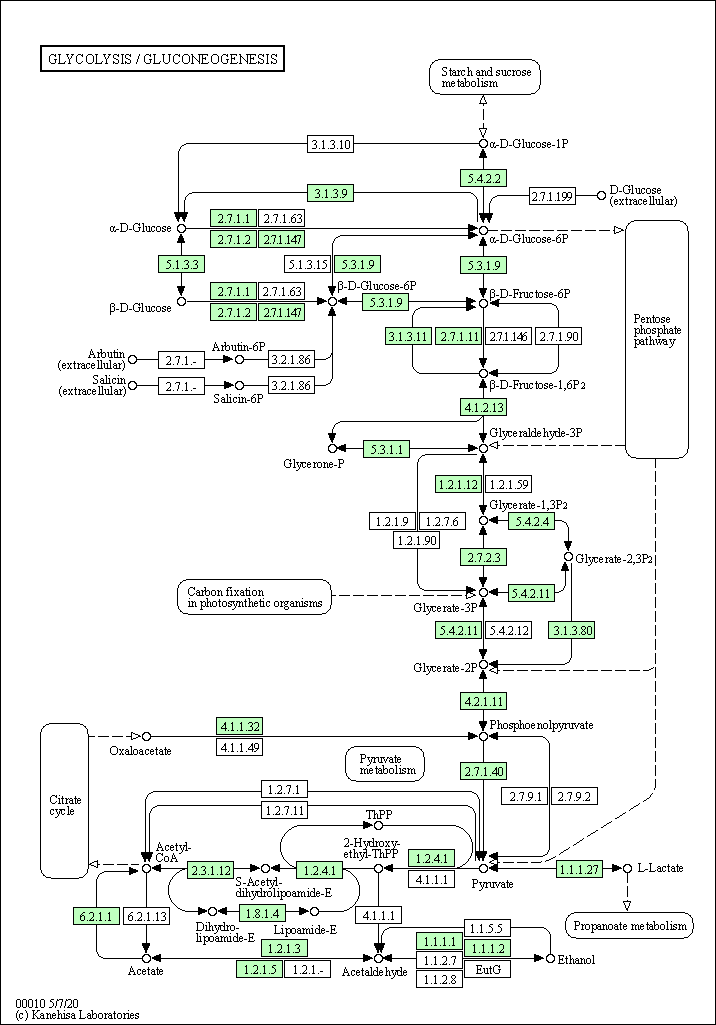

In [17]:
Image(kegg_get('path:mmu00010','image').read())